# REINFORCE

---

In this notebook, we will train the REINFORCE Algorithm with OpenAI Gym's Cartpole environment.

### Import the Necessary Packages

In [56]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [57]:
# Python Virtual Display
!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Define the Architecture of the Policy

In [58]:
env = gym.make('CartPole-v0')
env.seed(24)
print('observation space:', env.observation_space)
print('observation space low:', env.observation_space.low)
print('observation space high:', env.observation_space.high)
print('action space:', env.action_space)

observation space: Box(4,)
observation space low: [ -4.80000019e+00  -3.40282347e+38  -4.18879032e-01  -3.40282347e+38]
observation space high: [  4.80000019e+00   3.40282347e+38   4.18879032e-01   3.40282347e+38]
action space: Discrete(2)


In [59]:
class Policy(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_size=16):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        """ Forward Pass """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # Get probabilities of each action
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        # Creates a categorical distribution parameterized by either probs
        action_distribution = torch.distributions.Categorical(probs)
        action = action_distribution.sample()
        return action.item(), action_distribution.log_prob(action)

# Train the Agent with REINFORCE

In [60]:
policy = Policy(env.observation_space.shape[0], action_size=2).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [61]:
def reinforce(n_episodes=1000,
              max_t=1000,
              gamma=1.0,
              print_every=100):
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    for episodes in range(1, n_episodes+1):
        
        saved_log_probs = []
        rewards = []
        
        state = env.reset()
        
        for t in range(max_t):
            
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        # Calculate total return for episode/trajectory
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            # For each time step, append log probability * reward
            # Negative loss to ensure gradient ascent: weight = weight - (- gradient)
            policy_loss.append(-log_prob * R)
         
        # Calculate Policy Loss as summation of log probability * reward 
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if episodes % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(episodes, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episodes, np.mean(scores_deque)))
            break
        
    return scores

In [62]:
scores = reinforce()

Episode 100	Average Score: 22.73
Episode 200	Average Score: 60.23
Episode 300	Average Score: 58.94
Episode 400	Average Score: 86.35
Episode 500	Average Score: 88.71
Episode 600	Average Score: 142.82
Episode 700	Average Score: 145.93
Episode 800	Average Score: 175.68
Episode 900	Average Score: 171.51
Environment solved in 998 episodes!	Average Score: 195.81


### Plot the Scores

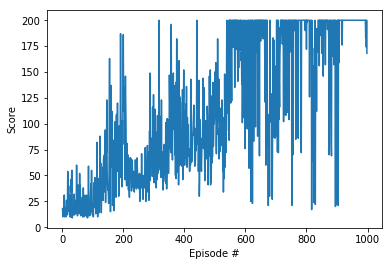

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent!

In [ ]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()